[i 0403 22:08:46.441457 56 cuda_flags.cc:32] CUDA enabled.


[1,3,224,224,]
jt.Var([[[ 2.0412657  -0.9855165  -0.06972819 ...  0.4624071   1.4215223
    0.54618174]
  [ 0.8376895  -0.1337667   0.03430518 ... -1.1182238   0.12729344
    0.09886493]
  [ 0.7507518  -0.08451089 -0.46057865 ... -0.53201413  0.53865975
   -0.18606547]
  ...
  [ 1.298056   -0.0504941   0.74111295 ... -0.07779549  0.1569778
   -0.88963884]
  [ 1.564015    0.07490025  0.6710159  ... -0.18560849  0.22047958
   -0.54007536]
  [ 1.163703    0.00431745  0.53696686 ... -0.3960352   0.57215106
   -0.35864678]]], dtype=float32)
jt.Var([[[-0.00264253  0.02643913 -0.00816691 ...  0.02000066 -0.00220386
   -0.00854872]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[0.56388974 0.56388974 0.56388974 ... 0.5809335  0.5809335
    0.5809335 ]
   [0.56388974 0.56388974 0.56388974 ... 0.5809335  0.5809335
    0.5809335 ]
   [0.56388974 0.56388974 0.56388974 ... 0.5809335  0.5809335
    0.5809335 ]
   ...
   [0.40842035 0.40842035 0.40842035 ... 0.6032181  0.6032181
    0.6032181 ]
   [0.40842035 0.40842035 0.40842035 ... 0.6032181  0.6032181
    0.6032181 ]
   [0.40842035 0.40842035 0.40842035 ... 0.6032181  0.6032181
    0.6032181 ]]]]


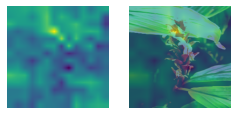

In [2]:
import jittor as jt
from jittor import init
from jittor import nn
from jittor import models
import argparse
from utils import *
from cam.layercam import *
from ViT import VisionTransformer

jt.flags.use_cuda = 1


def get_arguments():
    # args, unknown = parser.parse_known_args()
    parser = argparse.ArgumentParser(description='The Pytorch code of LayerCAM')
    parser.add_argument('--img_path', type=str, default='../../data/test/60/image_06247.jpg', help='Path of test image')
    parser.add_argument('--layer_id', type=list, default=['norm'], help='The cam generation layer') #, 9, 16, 23, 30
    # images/ILSVRC2012_val_00000476.JPEG
    return parser.parse_known_args()#parser.parse_args()
    
if (__name__ == '__main__'):
    args,_ = get_arguments()
    input_image = load_image(args.img_path)
    input_ = apply_transforms(input_image)
    print(input_.shape)

    #======================== ViT ==============================
    vitModel = VisionTransformer(img_size=224,patch_size=16, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3.,num_classes=1020)
    vitModel.load("../../model/ViT/finetuned_2_2.pkl")
    # print(vitModel)
    # print(vitModel._modules.keys())
    # fsdhkj
    optimizer = nn.SGD(vitModel.parameters(), 0.1)
    for i in range(len(args.layer_id)):
        layer_name = (str(args.layer_id[i])) #'features_' + 
        vit_model_dict = dict(type='ViT', arch=vitModel, layer_name=layer_name, input_size=(224, 224))
        vit_layercam = LayerCAM(vit_model_dict, optimizer)
        predicted_class = vitModel(input_).max(1)[(- 1)]
        layercam_map = vit_layercam(input_)
        print(layercam_map.numpy())
        basic_visualize(input_.numpy(), layercam_map.numpy(), save_path='./vis/image_06247_2.png')